In [458]:
from __future__ import division
from code.organize import *
from code.roughEDA import *
from code.survey_processor import *

import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [482]:
sv = survey('data/survey/')

In [483]:
sv.processor()

In [484]:
df = sv.fin_data

In [485]:
df_r = sv.data

In [7]:
y = df.pop('employed').values

In [8]:
X = df.values

In [23]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs =-1)

In [25]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
rf.score(X_test,y_test)

0.83906770255271923

In [27]:
from sklearn.grid_search import GridSearchCV

In [107]:
rf_gridsearch = {'n_estimators': [100,200], "criterion": ['gini','entropy']}

In [108]:
rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             rf_gridsearch,
                             n_jobs=-1,
                             verbose=True,
                             scoring='accuracy')
rf_gridsearch.fit(X_train,y_train)
print "best parameters:", rf_gridsearch.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    4.2s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    6.2s finished


best parameters: {'n_estimators': 200, 'criterion': 'entropy'}


In [109]:
best_model = rf_gridsearch.best_estimator_
best_fit = best_model.fit(X_train,y_train)
best_fit.score(X_test,y_test)

0.87791342952275253

In [88]:
best_model.feature_importances_.argsort()[::-1][:10]

array([175,  11,  10, 172,   1, 176,   0,   2,   5,   8])

In [95]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, best_fit.predict_proba(X_test)[:,1])

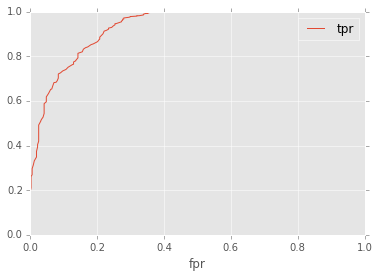

In [96]:
roc = pd.DataFrame({"fpr":fpr,"tpr": tpr})
roc.plot(x = "fpr", y = 'tpr')

In [110]:
roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])

0.93318088594961557

In [111]:
roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

0.88589752026234114

In [150]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [151]:
a = df_r[sv.survey_cols].degree.unique()

In [152]:
le.fit(a)

LabelEncoder()

In [154]:
b = le.fit_transform(df_r.degree)

In [155]:
le.inverse_transform(b)

array([u'High school', u'Bachelor', u'Bachelor', ..., u'Lt high school',
       u'Bachelor', u'Bachelor'], dtype=object)

In [163]:
le.classes_

array([u'Bachelor', u"Don't know", u'Graduate', u'High school',
       u'Junior college', u'Lt high school', u'No answer'], dtype=object)

In [171]:
with open('data/survey/GSS.sps') as f:
    content = f.readlines()

In [199]:
for c in content:
    if c.strip()=='VALUE LABELS':
        ind = content.index(c)+1
lis = []
for i in xrange(ind,len(content)-2):
    if content[i].strip().strip('/').strip()[0].isalpha()==True:
        lis.append(i)
        

In [261]:
x = [(lis[i],lis[i+1]) for i in xrange(len(lis)-1) ]
x.append((lis[-1],len(content)-3))

In [422]:
from collections import defaultdict
d3 = {}
for k,v in d.iteritems():
    d2 = defaultdict(int)
    for i in v:
        text = " ".join(i.strip().split()[1:])
        d2[re.findall('"([^"]*)"', text)[0]] = int(i.strip().split()[0])
        d3[k] = d2

In [454]:
d4 = {}
for i in x:
    a = content[i[0]:i[1]]
    d4[a[0].strip().strip("/").strip().lower()] = a[1:]

In [456]:
d4==d

True

In [447]:
d

{'affrmact': ['      9        "No answer"\r\n',
  '      8        "Don\'t know"\r\n',
  '      4        "Strongly oppose pref"\r\n',
  '      3        "Oppose pref"\r\n',
  '      2        "Support pref"\r\n',
  '      1        "Strongly support pref"\r\n',
  '      0        "Not applicable"\r\n'],
 'age': ['      99       "No answer"\r\n',
  '      98       "Don\'t know"\r\n',
  '      89       "89 or older"\r\n'],
 'agekdbrn': ['      99       "No answer"\r\n',
  '      98       "Don\'t know"\r\n',
  '      0        "Not applicable"\r\n'],
 'babies': ['      9        "No answer"\r\n',
  '      8        "8 or more"\r\n'],
 'class_': ['      9        "No answer"\r\n',
  '      8        "Don\'t know"\r\n',
  '      5        "No class"\r\n',
  '      4        "Upper class"\r\n',
  '      3        "Middle class"\r\n',
  '      2        "Working class"\r\n',
  '      1        "Lower class"\r\n',
  '      0        "Not applicable"\r\n'],
 'colath': ['      9        "No answer"\r\n',
  '    

In [385]:
d3['incom16']

defaultdict(list,
            {'Above average': 4,
             'Average': 3,
             'Below average': 2,
             "Don't know": 8,
             'Far above average': 5,
             'Far below average': 1,
             'Lived in institution': 7,
             'No answer': 9,
             'Not applicable': -1})

In [442]:
for col in s[:-1]:
    df_r[col] = df_r[col].apply(lambda x: d3[col][x])

In [486]:
dictn = extr_val_labels('data/survey/GSS.sps')

In [490]:
dictn.values() == d3.values()

False

In [491]:
dictn

{'affrmact': defaultdict(int,
             {"Don't know": 8,
              'No answer': 9,
              'Not applicable': 0,
              'Oppose pref': 3,
              'Strongly oppose pref': 4,
              'Strongly support pref': 1,
              'Support pref': 2}),
 'age': defaultdict(int,
             {'89 or older': 89, "Don't know": 98, 'No answer': 99}),
 'agekdbrn': defaultdict(int,
             {"Don't know": 98, 'No answer': 99, 'Not applicable': 0}),
 'babies': defaultdict(int, {'8 or more': 8, 'No answer': 9}),
 'class_': defaultdict(int,
             {"Don't know": 8,
              'Lower class': 1,
              'Middle class': 3,
              'No answer': 9,
              'No class': 5,
              'Not applicable': 0,
              'Upper class': 4,
              'Working class': 2}),
 'colath': defaultdict(int,
             {'Allowed': 4,
              "Don't know": 8,
              'No answer': 9,
              'Not allowed': 5,
              'Not applicable

In [469]:
d3['incom16']

defaultdict(int,
            {'Above average': 4,
             'Average': 3,
             'Below average': 2,
             "Don't know": 8,
             'Far above average': 5,
             'Far below average': 1,
             'Lived in institution': 7,
             'No answer': 9,
             'Not applicable': -1,
             '[(115, 126), (126, 133), (133, 137), (137, 141), (141, 145), (145, 149), (149, 153), (153, 157), (157, 161), (161, 170), (170, 176), (176, 186), (186, 189), (189, 192), (192, 199), (199, 206), (206, 213), (213, 220), (220, 227), (227, 234), (234, 241), (241, 247), (247, 253), (253, 259), (259, 265), (265, 273), (273, 282), (282, 289), (289, 296), (296, 303), (303, 310), (310, 317), (317, 326), (326, 335), (335, 344), (344, 352), (352, 358), (358, 367), (367, 374), (374, 383), (383, 391), (391, 401), (401, 407), (407, 415), (415, 423), (423, 431), (431, 438), (438, 445), (445, 453), (453, 461), (461, 469), (469, 478), (478, 487), (487, 491)]': 0,
             '

In [488]:
for col in s[:-1]:
    df_r[col] = df_r[col].apply(lambda x: dictn[col][x])

,degree,mawrkgrw,incom16,natspac,nateduc,natarms,natfare,natsoc,natpark,natfarey,...,fepresch,fefam,helpsick,discaff,fejobaff,discaffm,discaffw,goodlife,meovrwrk,employed
0,1,2,1,2,1,3,3,1,1,0,...,0,0,3,0,0,0,0,0,3,True
3,3,2,-1,2,1,2,1,2,2,0,...,2,3,0,3,0,0,0,0,0,False
4,3,1,-1,3,1,3,3,3,2,0,...,2,2,0,3,0,0,0,2,0,False
5,4,1,-1,3,1,2,3,8,1,0,...,4,4,0,2,0,0,0,0,0,False
6,1,1,-1,0,0,0,0,2,1,1,...,2,3,0,0,0,0,0,0,4,False
8,2,2,4,2,1,2,3,2,1,0,...,4,3,0,0,0,0,0,0,1,False
10,4,1,2,3,1,3,3,2,2,0,...,3,4,3,0,0,0,0,0,4,True
11,3,2,3,3,1,3,2,1,2,0,...,4,3,0,0,0,0,0,0,8,False
13,0,1,2,0,0,0,0,2,1,1,...,0,0,1,0,0,0,0,2,0,False
14,1,1,2,3,1,3,3,1,1,0,...,0,0,1,0,0,0,0,0,0,True
